In [ ]:
import pandas
import numpy as np
from collections import Counter
from sklearn.linear_model import LinearRegression as LR
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt

Cargo los datos a memoria de la tabla convertida a csv. Leer excel es más lento.

In [ ]:
data = pandas.read_csv('Proyecto_PreciosPyme_Base1.csv',header=0,sep=';',low_memory=False)

Parte de los datos no tienen registros completos.
Primero elimino los registros que tienen el campo "% Descuento% igual a cero, ya que la tasa entregada fue de cero. Son 820 registros por lo que no impacta la base de datos. 


In [ ]:
data = data.loc[data['% Descuento']!='Err:512']
data = data.loc[data['MON PROM']!='Err:512']

Cambio "Var pos neg" a variable numerica para que pueda ser operado fácilmente.

In [4]:
data['Var pos neg'].replace('POSIT',1,inplace=True)
data['Var pos neg'].replace('NEG',-1,inplace=True)

El objetivo es una regresión, nombres e identificadores no son útiles, por lo que se sacan de la base de datos.

Queda probar con:
- 'nom_cli_cat' para ver la diferencia entre Negocio y Pyme.
- "" para el tipo de Pyme, como Negocio, Pyme1 o Pyme 2.
- 'nom_sub_cat' para el rubro asociado.

- 'zona_nueva' para incluír la información geográfica.

- 'cargo_ejec_gest_rrhh' para incluír la información del ejecutivo.

- 'id_prod_conc' para incluír información sobre el tipo de producto.

Elimino las columnas sin información útil o redundante.

In [5]:
col_del = ['Periodo','fec_info','rut_clie','nom_clie','cli_cat','cli_cat_sub',
          'fec_otorg','Zonal','grp_suc','cod_ctr','rut_ejec_gest','nom_ejec_gest',
           'cargo_conc_gest','suc_gest_ejec','nom_suc_gest','zona_nueva_gest','id_orden_prod',
           'plazo','tramo','tipo_flujo','fecha_otorgamiento','prod_gsc','peso_ctr','plan','concepto_especifico',
           'GLOSA CODIGO ACTIVIDAD BANCO','GLOSA ACTIVIDAD CIIU','RUT_CORTO',
           'Octubre 2015_IND_CTA_CTA','Noviembre 2015_IND_CTA_CTA','Diciembre 2015_IND_CTA_CTA','Enero 2016_IND_CTA_CTA',
           'Febrero 2016_IND_CTA_CTA','Marzo 2016_IND_CTA_CTA','Abril 2016_IND_CTA_CTA','Mayo 2016_IND_CTA_CTA','Junio 2016_IND_CTA_CTA',
           'Julio 2016_IND_CTA_CTA','Agosto 2016_IND_CTA_CTA','FAM_201609_IND_CTA_CTA','FAM_201610_IND_CTA_CTA','FAM_201611_IND_CTA_CTA',
           'FAM_201612_IND_CTA_CTA','FAM_201701_IND_CTA_CTA','FAM_201702_IND_CTA_CTA',
          'Tramo Tasa','Tramo ACTSM1','Tramo ACTSM2','Tramo ACTSM3','Tramo ACTSM4','Tramo ACTSM5','Tramo ACTSM6','Tramo ACTSM7',
           'Tramo ACTSM8','Tramo ACTSM9','Tramo ACTSM10','Tramo ACTSM11','Tramo ACTSM12','Tramo ACTSM13','Tramo ACTSM14','Tramo ACTSM15',
           'Tramo ACTSM16','Tramo ACTSM17','CONCSMACT','Media_SM','Var pos neg'
           ,'opers','dia_otorg','cta_actual','extin_cdto',
           'id_plazo','id_tramo','id_tasa','grp','tasa_0',
           'modelo_id_riesgo','perfil_riesgo','ajuste_max','descuento','plazo_meses',
          'Marca_Conta','Marca_Campaña','Marca_Renegociados','Marca_Alivio','Marca_Carterizado','MarcaCanal','MarcaFFVV','NOM_GRP'
           ,'% Descuento'
           ,'nom_cli_cat','id_univ','nom_sub_cat','zona_nueva','cargo_ejec_gest_rrhh','id_prod_conc'
]

data.drop(col_del,1,inplace=True)

Elimino las columnas que no tienen la informacion temporal completa. Notar que fue eliminada para todos los registros.

In [6]:
del_act_desc_sm = ['FAM_201609_LdN_ACT_Descubiertos_SM','FAM_201610_LdN_ACT_Descubiertos_SM',
                   'FAM_201611_LdN_ACT_Descubiertos_SM','FAM_201612_LdN_ACT_Descubiertos_SM',
                   'FAM_201701_LdN_ACT_Descubiertos_SM','FAM_201702_LdN_ACT_Descubiertos_SM']
del_ldn_pas_mg = ['Junio 2016_LdN_PAS_MG','Julio 2016_LdN_PAS_MG','Agosto 2016_LdN_PAS_MG',
                  'FAM_201609_LdN_PAS_MG','FAM_201610_LdN_PAS_MG','FAM_201611_LdN_PAS_MG',
                  'FAM_201612_LdN_PAS_MG','FAM_201701_LdN_PAS_MG','FAM_201702_LdN_PAS_MG']
del_ldn_resto_sm = ['Octubre 2015_LdN_ACT_RESTO_CREDITO_SM','Noviembre 2015_LdN_ACT_RESTO_CREDITO_SM',
                    'Diciembre 2015_LdN_ACT_RESTO_CREDITO_SM','Enero 2016_LdN_ACT_RESTO_CREDITO_SM',
                    'Junio 2016_LdN_ACT_RESTO_CREDITO_SM','Julio 2016_LdN_ACT_RESTO_CREDITO_SM',
                    'Agosto 2016_LdN_ACT_RESTO_CREDITO_SM','FAM_201609_LdN_ACT_RESTO_CREDITO_SM',
                    'FAM_201610_LdN_ACT_RESTO_CREDITO_SM','FAM_201611_LdN_ACT_RESTO_CREDITO_SM',
                    'FAM_201612_LdN_ACT_RESTO_CREDITO_SM','FAM_201701_LdN_ACT_RESTO_CREDITO_SM',
                    'FAM_201702_LdN_ACT_RESTO_CREDITO_SM']
del_ldn_resto_mg = ['Febrero 2016_LdN_ACT_RESTO_CREDITO_MG','Marzo 2016_LdN_ACT_RESTO_CREDITO_MG','Junio 2016_LdN_ACT_RESTO_CREDITO_MG',
                    'Julio 2016_LdN_ACT_RESTO_CREDITO_MG','Agosto 2016_LdN_ACT_RESTO_CREDITO_MG','FAM_201609_LdN_ACT_RESTO_CREDITO_MG',
                    'FAM_201610_LdN_ACT_RESTO_CREDITO_MG','FAM_201611_LdN_ACT_RESTO_CREDITO_MG','FAM_201612_LdN_ACT_RESTO_CREDITO_MG',
                    'FAM_201701_LdN_ACT_RESTO_CREDITO_MG','FAM_201702_LdN_ACT_RESTO_CREDITO_MG']
del_ldn_act_mg = ['Junio 2016_LdN_ACT_MG','Julio 2016_LdN_ACT_MG','Agosto 2016_LdN_ACT_MG',
                  'FAM_201609_LdN_ACT_MG','FAM_201610_LdN_ACT_MG','FAM_201611_LdN_ACT_MG',
                  'FAM_201612_LdN_ACT_MG','FAM_201701_LdN_ACT_MG','FAM_201702_LdN_ACT_MG']
del_ldn_act_fact_mg = ['FAM_201609_LdN_ACT_Factoring_MG','FAM_201610_LdN_ACT_Factoring_MG','FAM_201611_LdN_ACT_Factoring_MG',
                       'FAM_201612_LdN_ACT_Factoring_MG','FAM_201701_LdN_ACT_Factoring_MG','FAM_201702_LdN_ACT_Factoring_MG']
del_ldn_act_desc_mg = ['FAM_201609_LdN_ACT_Descubiertos_MG','FAM_201610_LdN_ACT_Descubiertos_MG','FAM_201611_LdN_ACT_Descubiertos_MG',
                       'FAM_201612_LdN_ACT_Descubiertos_MG','FAM_201701_LdN_ACT_Descubiertos_MG','FAM_201702_LdN_ACT_Descubiertos_MG']
del_ldn_act_fact_sm = ['FAM_201609_LdN_ACT_Factoring_SM','FAM_201610_LdN_ACT_Factoring_SM','FAM_201611_LdN_ACT_Factoring_SM',
                       'FAM_201612_LdN_ACT_Factoring_SM','FAM_201701_LdN_ACT_Factoring_SM','FAM_201702_LdN_ACT_Factoring_SM']

del_time_series = [del_act_desc_sm,del_ldn_pas_mg,del_ldn_resto_sm,del_ldn_resto_mg,del_ldn_act_mg,
                  del_ldn_act_fact_mg,del_ldn_act_desc_mg,del_ldn_act_fact_sm]

for i in del_time_series:
    data.drop(i,1,inplace=True)

Una forma de proceder es usar sólo los préstamos en moneda local. En caso contrario incluir los créditos en uf o en moneda extranjera multiplicado por el monto. 

Para mantener la simplicidad del modelo, sólo se trabajará con moneda local.

In [7]:
data_mx = data.loc[data['Tipo_conta']=='Mx']
data_uf = data.loc[data['Tipo_conta']=='uf']
data_nr = data.loc[data['Tipo_conta']=='nr']

Como los datos de mx son 8800 y los de uf 9800, comparados con los 89000 de los créditos en pesos, se pueden remover sin alterar sustancialmente la base de datos. Se deja pendiente para un modelo más general.

Ahora, elimino las variables relacionadas con el tipo de moneda y el cambio.

In [8]:
data_nr = data_nr.drop(['Tipo_conta','tipo_camb_reaj','tipo_camb_mx'],1)

## Quitar datos faltantes
Elimino las filas que no tienen todos los valores completos.

In [9]:
data_nr.dropna(axis=0,how='any',inplace=True)

Después de filtrar los datos, los casos totales son 69000.

## Feature creation

Ahora, los valores temporales no pueden ser usados como features directamente, ya que son muchos. Además los créditos no ocurren al final, sino que a tiempos arbitrarios, por lo que no se puede asumir que se conoce el futuro. Por lo tanto se propone usar media, desviacion estandar, además de coeficientes de un ajuste lineal o cuadratico.

### Time series
Los nombres de las columnas con información temporal no son estandar. Se les cambiará el formato.

In [10]:
aa = np.array(list(data_nr.columns))

nme = ['MOB','LdN_ACT_SM','LdN_PAS_SM','_MON','_LdN_COMI']

for n in nme:
    ind1 = 10
    ind2 = 2015
    bb =aa[np.core.defchararray.find(aa,n)!=-1]


    bb1 = bb.copy()
    dic = {}
    for i in range(bb.shape[0]):
        bb1[i] = n+'_'+str(ind1).zfill(2)+'/'+str(ind2)
        ind1 = ind1%12
        ind1+=1
        if(ind1==1):
            ind2+=1
        dic[bb[i]]=bb1[i]
    data_nr.rename(index=str,columns=dic,inplace=True)

#### Estadísticos de time series

Los créditos se pidieron en fechas distintas, por lo que no puede considerarse todo el rango de tiempo ya que el banco no posee datos del futuro. 

Para abordar este problema, se calcularán estadísticos para describir la información temporal tomando en cueta los meses desde el inicio de los datos o la incorporación del cliente al banco, hasta el mes anterior al crédito.


Índices iniciales de las series de tiempo.

In [11]:
temp1 = list(data_nr.columns)
ini_index = [temp1.index('MOB_10/2015'),
temp1.index('LdN_ACT_SM_10/2015'),
temp1.index('LdN_PAS_SM_10/2015'),
temp1.index('_MON_10/2015'),
temp1.index('_LdN_COMI_10/2015')]
# ,temp1.index('MON1')]

In [12]:
intercept = []
pendiente = []
promedio =  []
std_dev  =  []

in_ = []

data_nr_mtx = data_nr.as_matrix()
ind_yr_otorg = temp1.index('año_otorg')
ind_mt_otorg = temp1.index('mes_otorg')

for j in range(len(nme)):
    intercept.append([])
    pendiente.append([])
    promedio.append([])
    std_dev.append([])
    for i in range(data_nr.shape[0]):
        yr = data_nr_mtx[i,ind_yr_otorg]
        mt = data_nr_mtx[i,ind_mt_otorg]
        #Si los creditos son demasiado recientes
        if(yr==2017 and mt>=2): 
            continue
        if(i not in in_):    
            in_.append(i)    

        lr  = LR()
        fnd = nme[j]+'_'+str(mt).zfill(2)+'/'+str(yr)

        dta = data_nr_mtx[i,ini_index[0]:temp1.index(fnd)]

        mean_ = np.mean(dta)
        std_ = np.mean(dta)

        promedio[j].append(mean_)
        std_dev[j].append(std_)
        
        
        lr.fit(np.array(range(dta.shape[0])).reshape(-1,1),dta)
        m_ = lr.coef_[0]
        c_ = lr.intercept_

        intercept[j].append(c_)
        pendiente[j].append(m_)
        

In [13]:
nmes = []
for j in range(len(nme)):
    nmes.append([])
    nmes[j].append(nme[j]+'_'+'Promedio')
    nmes[j].append(nme[j]+'_'+'St_dev')
    nmes[j].append(nme[j]+'_'+'Intercept')
    nmes[j].append(nme[j]+'_'+'Slope')    

Se eliminan los créditos recientes que no tienen suficientes datos para calcular los estadísticos. Quedan en total 55000.

In [14]:
data_nr = data_nr.iloc[in_].copy()

Luego de calcular las nuevas variables, se eliminan las series de tiempo.

In [15]:
#En cada columna
for i in temp1:
    for j in nme:
        if(j in i):
            data_nr.drop(i,1,inplace=True)
for i in data_nr.columns:            
    #Por ahora elimino MON
    if('MON' in i):
        data_nr.drop(i,1,inplace=True)

Se agregan las columnas en millones de pesos.

In [16]:
for i in range(len(nmes)):
    data_nr[nmes[i][0]] =  np.array(promedio[i])/1e6
    data_nr[nmes[i][1]] =  np.array(std_dev[i])/1e6
    data_nr[nmes[i][2]] =  np.array(intercept[i])/1e6
    data_nr[nmes[i][3]] =  np.array(pendiente[i])/1e6

#### Tiempo antiguedad

Puede que la cantidad de tiempo que el cliente está en el banco pueda afectar la cantidad de descuentos pedidos. 

Las variables asociadas serán:
- 'año_otorg'
- 'mes_otorg'
- 'AÑO_APERTURA_SA'
- 'MES_APERTURA_SA'

Año y mes otorg corresponden a el año y el mes del crédito, y apertura corresponde a la fecha en la que la cuenta fue abierta. 

Se considerará el tiempo en meses.


In [17]:
antiguedad = 12*(data_nr['año_otorg']-data_nr['AÑO_APERTURA_SA']) + data_nr['mes_otorg']-data_nr['MES_APERTURA_SA']

Ahora se agrega la variable "antiguedad" y se eliminan las variables anteriores. 

In [18]:
data_nr= data_nr.assign(antiguedad=antiguedad.values)

data_nr.drop(['año_otorg','mes_otorg','AÑO_APERTURA_SA','MES_APERTURA_SA'],1,inplace=True)

Elimino '% Descuento', ya que es información que se obtiene del ajuste.

## Regression Random Forest 
### Objetivos
El objetivo de este trabajo es tratar de predecir el valor de la tasa_act en base a la información del cliente. Por lo tanto, el objetivo es "tasa_act". 

Además hay que eliminar inforamción de "tasa_1_tarifado", "tasa_transf" y "spread", ya que es información del modelo antiguo. La variable "tasa_1" se usa para codificar la información del modelo anterior. En un modelo futuro se usará directamente la información de riesgo.

In [19]:
target =  data_nr['tasa_act'].as_matrix()
data_nr.drop(['tasa_act', "tasa_1_tarifado", "tasa_transf" , "spread"],1,inplace=True)

Elimino 'Tasa*mto', 'spread*monto' y 'margen_b'.

In [20]:
data_nr.drop(['Tasa*mto',"Spread*mto", "margen_b"],1,inplace=True)

Lo transformo a float.

In [21]:
mx = data_nr.as_matrix()

La matriz mx que contiene la información que se usará para el modelo final.


In [22]:
rfr = RandomForestRegressor(n_estimators=1000, criterion='mse', max_depth=None, 
                            min_samples_split=10, min_samples_leaf=20, 
                            min_weight_fraction_leaf=0.0, max_features='auto', 
                            max_leaf_nodes=None, min_impurity_split=1e-07, 
                            bootstrap=True, oob_score=True, n_jobs=7, warm_start=False)

In [23]:
NN = 40000
rfr.fit(mx[:NN,:], target[:NN])

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_split=1e-07, min_samples_leaf=20,
           min_samples_split=10, min_weight_fraction_leaf=0.0,
           n_estimators=1000, n_jobs=7, oob_score=True, random_state=None,
           verbose=0, warm_start=False)

In [36]:
rfr_pred = rfr.predict(mx[NN:])


Importancia de características.

In [33]:
fnl = np.asarray(list(zip(rfr.feature_importances_,list(data_nr.columns))))
fnl[np.flip(fnl[:,0].argsort(axis=0),0),:]

array([['0.771993204952', 'tasa_1'],
       ['0.0555418528862', 'plazos_dias'],
       ['0.0486897164786', 'mto_otorg'],
       ['0.0162308199269', 'Suma Var'],
       ['0.0113667813437', 'antiguedad'],
       ['0.011307349066', 'MOB_Slope'],
       ['0.00913576888649', 'MOB_Intercept'],
       ['0.0086130376852', 'n_cuotas_pact'],
       ['0.00833552010472', 'LdN_PAS_SM_Intercept'],
       ['0.0083202655906', 'LdN_PAS_SM_Slope'],
       ['0.00812861182028', '_MON_Slope'],
       ['0.00455774013704', 'MOB_St_dev'],
       ['0.00450129387207', 'MOB_Promedio'],
       ['0.00418729642464', 'LdN_ACT_SM_Intercept'],
       ['0.00412749125018', '_LdN_COMI_Slope'],
       ['0.0039795987015', 'LdN_ACT_SM_Promedio'],
       ['0.00395709330378', 'LdN_ACT_SM_St_dev'],
       ['0.0033865710826', '_MON_Intercept'],
       ['0.00293347124855', '_LdN_COMI_Intercept'],
       ['0.00276135542788', 'LdN_ACT_SM_Slope'],
       ['0.00151631041265', 'LdN_PAS_SM_St_dev'],
       ['0.00148490264358', 'LdN_PA

### Evaluación 

Los criterios para evaluar serán "Root Mean Squared Error" y "R^2". 

El primero indica la desviación del modelo de los datos, y el segundo el ajuste general de la regresión.

Tenemos que los valores para el modelo actual son de:

In [37]:
np.sqrt(mean_squared_error(target[NN:],data_nr['tasa_1'][NN:]))

0.25363542473053596

In [40]:
r2_score(target[NN:],data_nr['tasa_1'][NN:])

0.38076639931915712

Mientras que para los obtenido con el modelo son:

In [41]:
np.sqrt(mean_squared_error(target[NN:],rfr_pred))

0.19359145667468308

In [42]:
r2_score(target[NN:],rfr_pred)

0.63924939480621845

### Histogramas

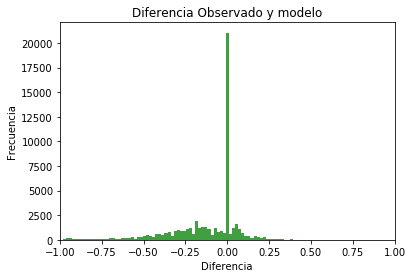

In [95]:
# n, bins, patches = plt.hist(target[NN:]-data_nr['tasa_1'][NN:], 200, normed=0, facecolor='green', alpha=0.75)
n, bins, patches = plt.hist(target-data_nr['tasa_1'], 200, normed=0
                            , facecolor='green', alpha=0.75)
plt.xlabel('Diferencia')
plt.ylabel('Frecuencia')
plt.title('Diferencia Observado y modelo')
# plt.axis([40, 160, 0, 0.03])
# plt.grid(True)
plt.xlim(-1,1)
plt.show()

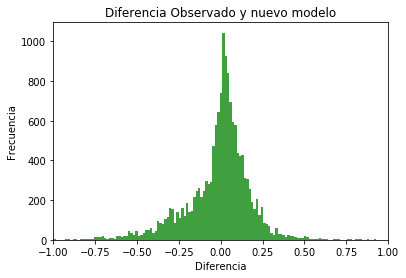

In [89]:
n, bins, patches = plt.hist(target[NN:]-rfr_pred, 'auto', normed=0
                            , facecolor='green', alpha=0.75,align='mid')

plt.xlabel('Diferencia')
plt.ylabel('Frecuencia')
plt.title('Diferencia Observado y nuevo modelo')
# plt.axis([40, 160, 0, 0.03])
# plt.grid(True)
plt.xlim(-1,1)
plt.show()

Falta inforporar nuevas características y estudiar el impacto de este modelo sobre los ingresos del banco.

In [96]:
import pickle

In [97]:
pickle.dump( data_nr, open( "data_nr.p", "wb" ) )
pickle.dump( rfr, open( "rfr.p", "wb" ) )